# Exercise 13.1 
In NSFG Cycles 6 and 7, the variable cmdivorcx contains the date of divorce for the respondent’s first marriage, if applicable, encoded in century-months.
Compute the duration of marriages that have ended in divorce, and the duration, so far, of marriages that are ongoing. Estimate the hazard and survival curve for the duration of marriage.
Use resampling to take into account sampling weights, and plot data from several resamples to visualize sampling error.
Consider dividing the respondents into groups by decade of birth, and pos- sibly by age at first marriage.

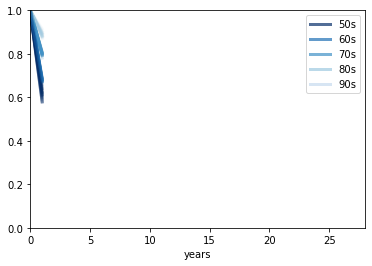

<Figure size 576x432 with 0 Axes>

In [4]:
from __future__ import print_function

import pandas
import numpy as np

import thinkplot
import thinkstats2
import survival


def CleanData(resp):
    """Function for cleaning the respondant data"""
    
    resp.cmdivorcx.replace([9998, 9999], np.nan, inplace=True)

    resp['notdivorced'] = resp.cmdivorcx.isnull().astype(int)
    resp['duration'] = (resp.cmdivorcx - resp.cmmarrhx) / 12.0
    resp['durationsofar'] = (resp.cmintvw - resp.cmmarrhx) / 12.0

    month0 = pandas.to_datetime('1899-12-15')
    dates = [month0 + pandas.DateOffset(months=cm) 
             for cm in resp.cmbirth]
    resp['decade'] = (pandas.DatetimeIndex(dates).year - 1900) // 10




def ResampleDivorceCurveByDecade(resps):
    """Function for plotting divorce curves for each birth cohort. """
    
    for i in range(41):
        samples = [thinkstats2.ResampleRowsWeighted(resp) 
                   for resp in resps]
        sample = pandas.concat(samples, ignore_index=True)
        groups = sample.groupby('decade')
        if i == 0:
            survival.AddLabelsByDecade(groups, alpha=0.7)

        EstimateSurvivalByDecade(groups, alpha=0.1)

    thinkplot.Show(root='survival7',
                   xlabel='years',
                   axis=[0, 28, 0, 1])


def EstimateSurvivalByDecade(groups, **options):
    """Function for grouping respondents by decade and plotting survival curves."""
    
    thinkplot.PrePlot(len(groups))
    for name, group in groups:
        _, sf = EstimateSurvival(group)
        thinkplot.Plot(sf, **options)


def EstimateSurvival(resp):
    """Function for estimating the survival curve."""
    
    complete = resp[resp.notdivorced == 0].duration.notnull()
    ongoing = resp[resp.notdivorced == 1].durationsofar.notnull()
    hf = survival.EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf


def main():
    resp6 = survival.ReadFemResp2002()
    CleanData(resp6)
    married6 = resp6[resp6.evrmarry==1]

    resp7 = survival.ReadFemResp2010()
    CleanData(resp7)
    married7 = resp7[resp7.evrmarry==1]

    ResampleDivorceCurveByDecade([married6, married7])


if __name__ == '__main__':
    main()